<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-images" data-toc-modified-id="Loading-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading images</a></span></li><li><span><a href="#Loss-functions" data-toc-modified-id="Loss-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loss functions</a></span><ul class="toc-item"><li><span><a href="#Content-loss" data-toc-modified-id="Content-loss-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Content loss</a></span></li><li><span><a href="#Style-loss" data-toc-modified-id="Style-loss-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Style loss</a></span></li></ul></li><li><span><a href="#Importing-model" data-toc-modified-id="Importing-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing model</a></span></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gradient Descent</a></span></li><li><span><a href="#Running-model" data-toc-modified-id="Running-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running model</a></span></li></ul></div>

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import datetime

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading images

In [4]:
imsize = 512 if torch.cuda.is_available() else 128


# def image_loader(image_name):
#     loader = transforms.Compose([
#         transforms.Resize(imsize),
#         transforms.ToTensor()])
#     image = Image.open(image_name)
#     image = loader(image).unsqueeze(0)
#     return image.to(device, torch.float)

def image_loader(image_name):
    image = Image.open(image_name)
    r, c = image.size
    l = r if r<c else c
    box = (r/2-l/2, c/2-l/2, r/2+l/2, c/2+l/2)
    image = image.crop(box)
    loader = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/style/candy.jpg")
content_img = image_loader("./data/content/flowers.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

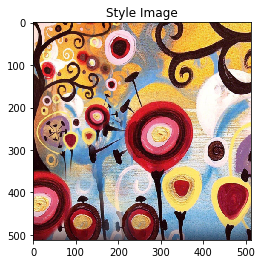

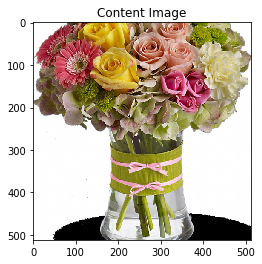

In [5]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
def saveimg(imgname, filename, title=None):
    image = imgname.cpu().clone()  
    image = image.squeeze(0)
    image = unloader(image)
    figure = plt.figure()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    figure.savefig(filename)

# Loss functions
## Content loss

In [9]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## Style loss

In [10]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  
    return G.div(a * b * c * d)

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importing model

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).cuda()
        self.std = torch.tensor(std).view(-1, 1, 1).cuda()

    def forward(self, img):
        return (img - self.mean) / self.std

In [14]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

<Figure size 432x288 with 0 Axes>

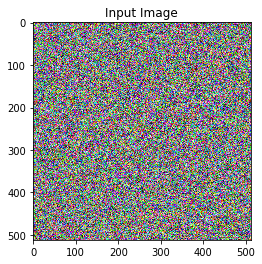

In [15]:
input_img = torch.randn(content_img.data.size(), device=device)  # white noise

plt.figure()
# imshow(input_img, title='Input Image')
saveimg(input_img, './data/output/noise.jpg', title='Input Image')

# Gradient Descent

In [16]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Running model

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=2000,
                       style_weight=1000000, content_weight=1):
    start_time = datetime.datetime.now()
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 200 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Time : {}'.format(
                    style_score.item(), content_score.item(), datetime.datetime.now()-start_time))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [200]:
Style Loss : 24.482428 Content Loss: 34.609146 Time : 0:00:43.961099

run [400]:
Style Loss : 6.168470 Content Loss: 26.369492 Time : 0:01:30.598893

Total training time: 0:01:35.341054


<Figure size 432x288 with 0 Axes>

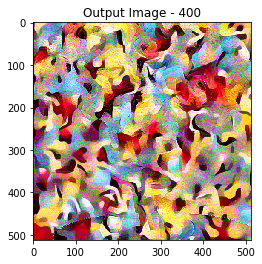

In [20]:
start_time = datetime.datetime.now()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=400)
print(f"Total training time: {datetime.datetime.now() - start_time}")

plt.figure()
saveimg(output, './data/output/v1_output_400.jpg', title='Output Image - 400')

plt.ioff()
plt.show()

Building the style transfer model..


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [200]:
Style Loss : 78.315712 Content Loss: 20.388838 Time : 0:00:44.232876

run [400]:
Style Loss : 35702.601562 Content Loss: 35.786949 Time : 0:01:31.125672

run [600]:
Style Loss : 83.729408 Content Loss: 47.306026 Time : 0:02:18.122528

run [800]:
Style Loss : 15.752215 Content Loss: 30.954439 Time : 0:03:05.221065

run [1000]:
Style Loss : 4.832573 Content Loss: 22.912199 Time : 0:03:52.450222

run [1200]:
Style Loss : 3.040857 Content Loss: 18.346012 Time : 0:04:39.776694

run [1400]:
Style Loss : 2.213137 Content Loss: 15.863111 Time : 0:05:27.066278

run [1600]:
Style Loss : 2058.893066 Content Loss: 51.328758 Time : 0:06:14.225033

Total training time: 0:06:18.995399


<Figure size 432x288 with 0 Axes>

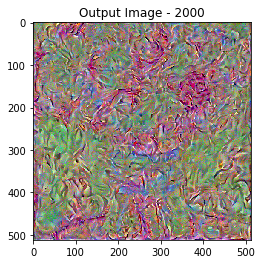

In [23]:
start_time = datetime.datetime.now()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1600)
print(f"Total training time: {datetime.datetime.now() - start_time}")

plt.figure()
saveimg(output, './data/output/v1_output_2k.jpg', title='Output Image - 2000')

plt.ioff()
plt.show()

Building the style transfer model..


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [200]:
Style Loss : 33.379890 Content Loss: 39.360886 Time : 0:00:44.731904

run [400]:
Style Loss : 12.643448 Content Loss: 29.694635 Time : 0:01:31.841451

run [600]:
Style Loss : 4.801024 Content Loss: 23.795572 Time : 0:02:18.834917

run [800]:
Style Loss : 3.132023 Content Loss: 19.787640 Time : 0:03:05.880296

run [1000]:
Style Loss : 1628.698608 Content Loss: 51.963902 Time : 0:03:52.923795

Total training time: 0:03:57.713958


<Figure size 432x288 with 0 Axes>

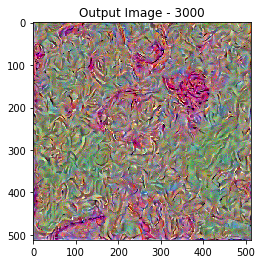

In [24]:
start_time = datetime.datetime.now()
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1000)
print(f"Total training time: {datetime.datetime.now() - start_time}")

plt.figure()
saveimg(output2, './data/output/v1_output_3k.jpg', title='Output Image - 3000')

plt.ioff()
plt.show()